In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as sig
import seaborn as sns
import pickle as pkl
import pandas as pd
import statsmodels.api as sm
import csv

try: data = pd.read_pickle('./tissue-mech.pkl') 
except:
    print('Error in loading data')

In [36]:
a = data['Block'] != 'B1'
df = data[a]
df = df.reset_index()
df['Group_R'] = df['Group']
df['Group_R'] = df['Group_R'].replace('2U','E2')
df['Group_R'] = df['Group_R'].replace('4U','E4')
df['Group_R'] = df['Group_R'].replace('8U','E8')

In [37]:
# ids = [1,2,3,4,5,6,8,9,10]
ids = [1,4,5]

_1hz_stretches = [df["1hz_stretch"][i] for i in ids]
_1hz_stresses  = [df["1hz_stress"][i] for i in ids]

_5hz_stretches = [df[".5hz_stretch"][i] for i in ids]
_5hz_stresses  = [df[".5hz_stress"][i] for i in ids]

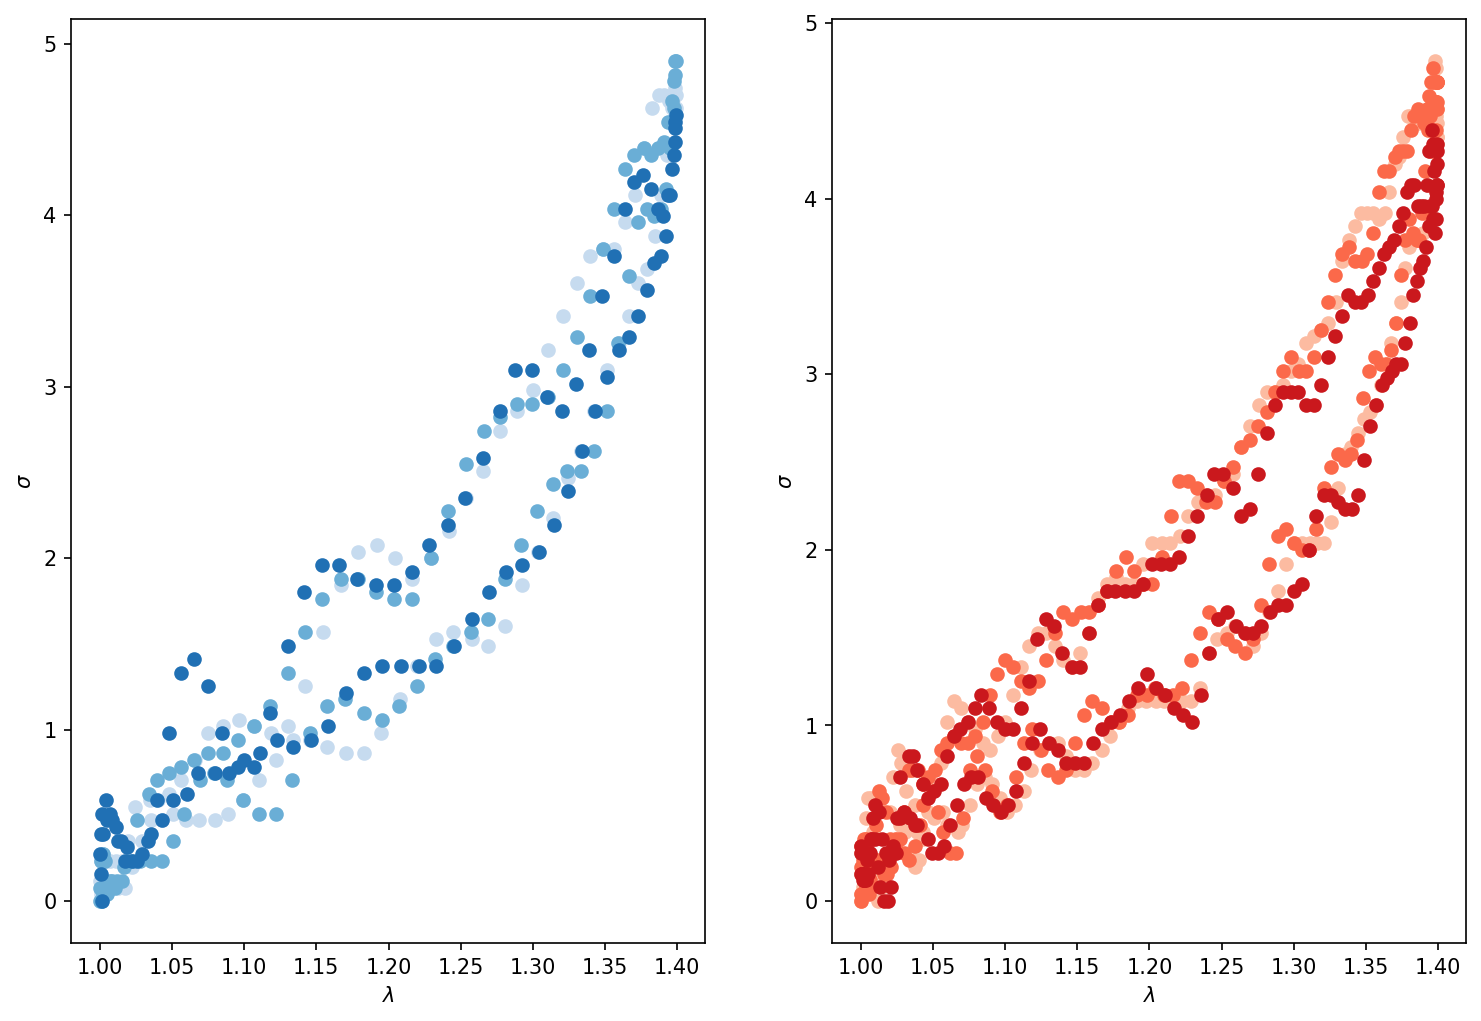

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,8), dpi=150)

cmap1 = sns.color_palette("Blues", len(ids))
cmap5 = sns.color_palette("Reds", len(ids))

for i in range(len(ids)):
    ax[0].scatter(_1hz_stretches[i], _1hz_stresses[i], color=cmap1[i])
    ax[0].set_xlabel(r"$\lambda$")
    ax[0].set_ylabel(r"$\sigma$")
    ax[1].scatter(_5hz_stretches[i], _5hz_stresses[i], color=cmap5[i])
    ax[1].set_xlabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\sigma$")

plt.show()

In [39]:
def butter_lowpass_filter(data, frac, order=1):
    b, a = sig.butter(order, Wn = frac*50, fs=100, btype='lowpass', analog=False)
    y = sig.filtfilt(b, a, data)
    return y

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,7), dpi=150)

for i in range(len(ids)):
    ax[0].plot(np.arange(*_1hz_stretches[i].shape), _1hz_stretches[i], color=cmap1[i])
    # ax[0].plot(_1hz_stretches[i], butter_lowpass_filter(_1hz_stresses[i], w), color=cmap1[i])
    ax[1].plot(np.arange(*_1hz_stretches[i].shape), _1hz_stretches[i], color=cmap5[i])
    # ax[1].plot(_5hz_stretches[i], butter_lowpass_filter(_5hz_stresses[i], w), color=cmap5[i])

plt.show()

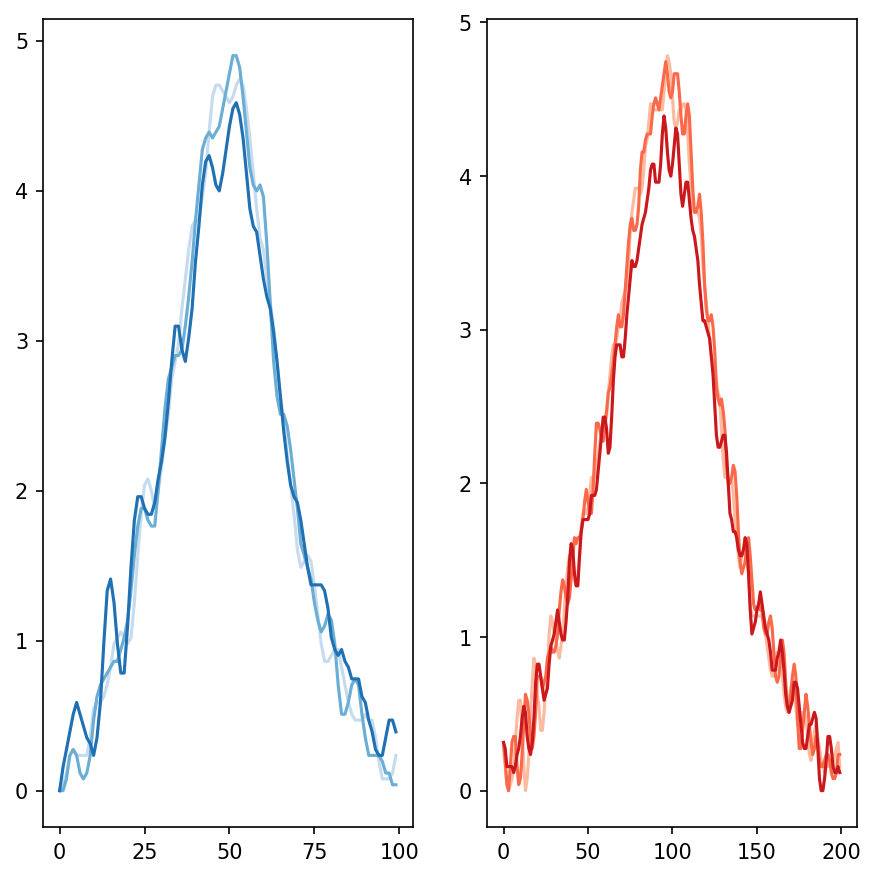

In [54]:
fig, ax = plt.subplots(1,2,figsize=(7,7), dpi=150)

for i in range(len(ids)):
    ax[0].plot(np.arange(*_1hz_stresses[i].shape), _1hz_stresses[i], color=cmap1[i])
    ax[0].plot(_1hz_stretches[i], butter_lowpass_filter(_1hz_stresses[i], w), color=cmap1[i])
    ax[1].plot(np.arange(*_5hz_stresses[i].shape), _5hz_stresses[i], color=cmap5[i])
    ax[1].plot(_5hz_stretches[i], butter_lowpass_filter(_5hz_stresses[i], w), color=cmap5[i])

plt.show()

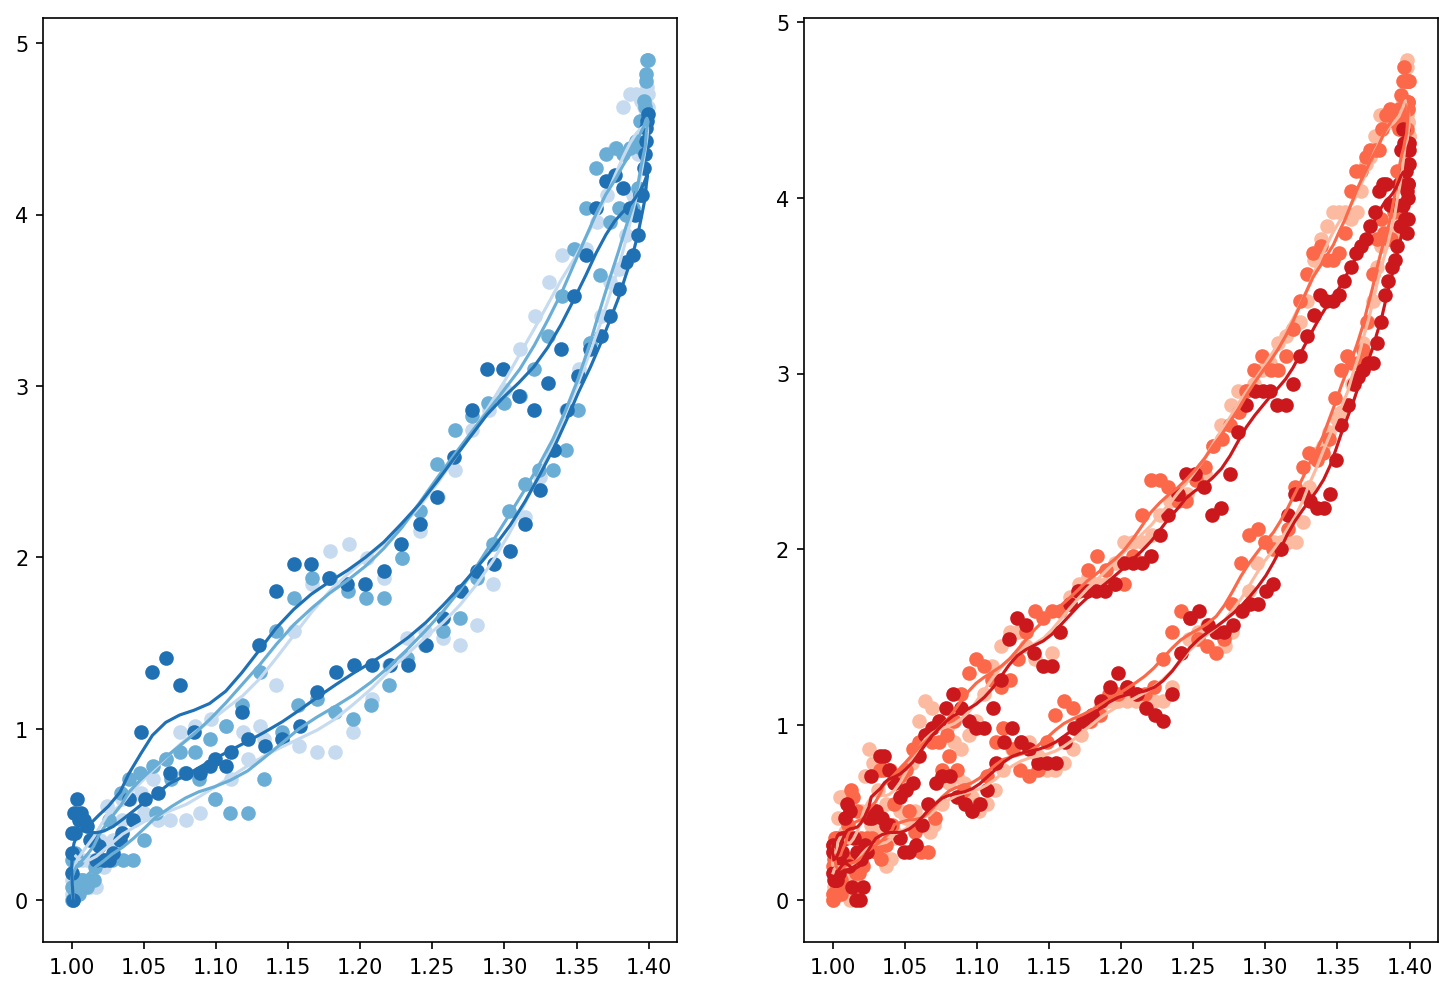

In [40]:
fig, ax = plt.subplots(1,2, figsize=(12,8), dpi=150)

cmap1 = sns.color_palette("Blues", len(ids))
cmap5 = sns.color_palette("Reds", len(ids))

w = 0.10

for i in range(len(ids)):
    ax[0].scatter(_1hz_stretches[i], _1hz_stresses[i], color=cmap1[i])
    ax[0].plot(_1hz_stretches[i], butter_lowpass_filter(_1hz_stresses[i], w), color=cmap1[i])
    ax[1].scatter(_5hz_stretches[i], _5hz_stresses[i], color=cmap5[i])
    ax[1].plot(_5hz_stretches[i], butter_lowpass_filter(_5hz_stresses[i], w), color=cmap5[i])

plt.show()

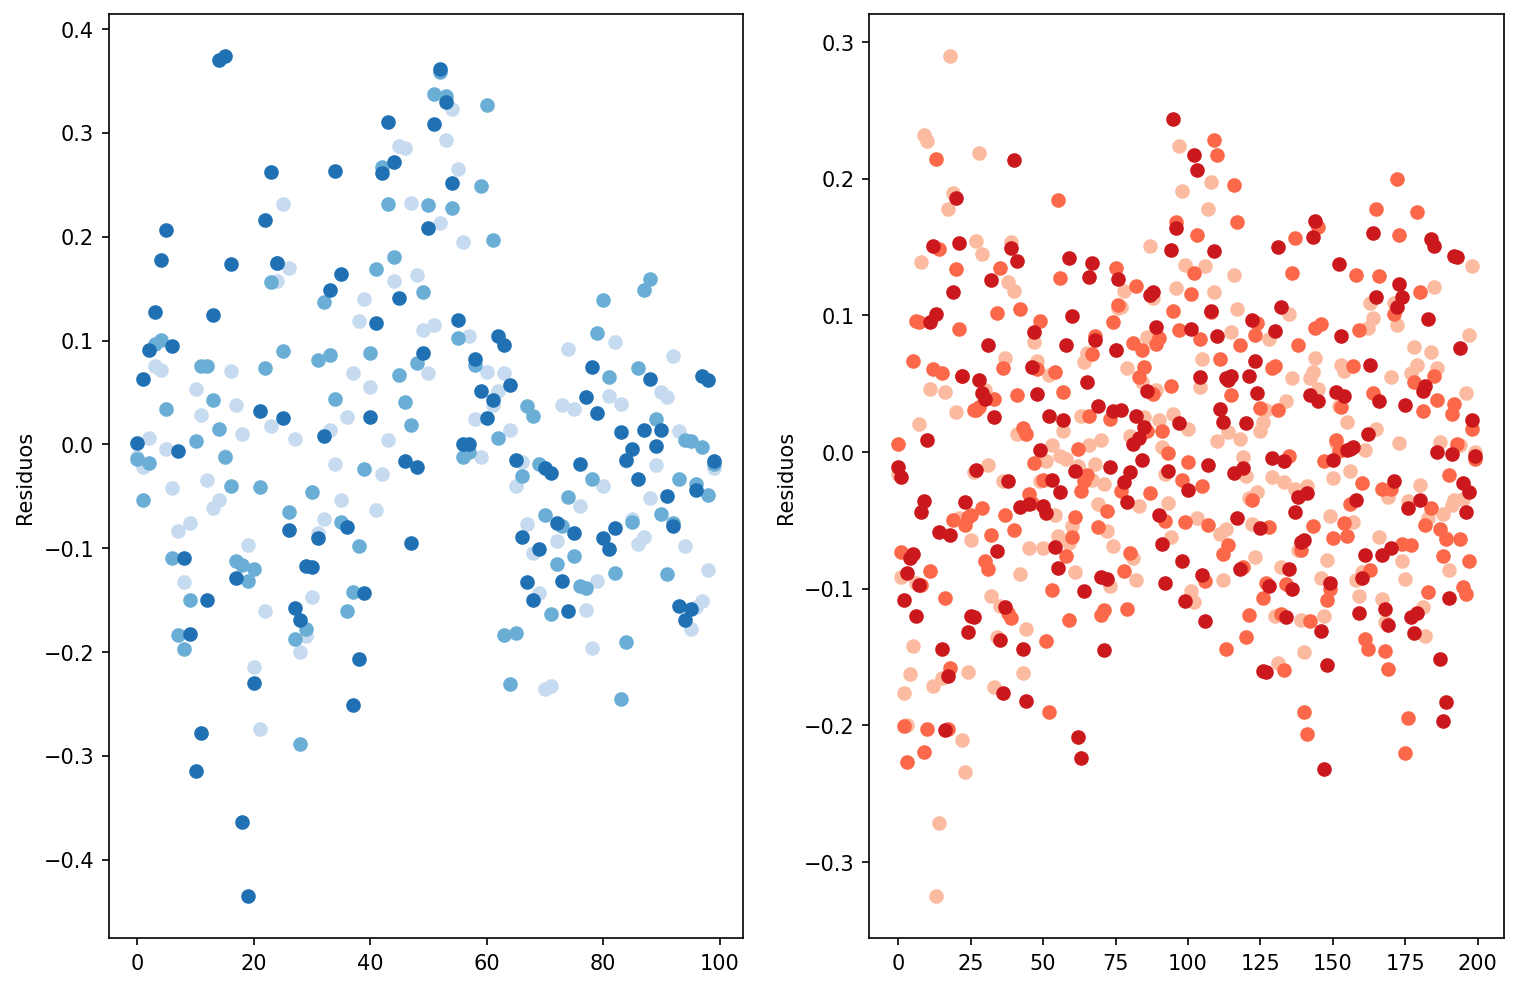

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

w = 0.10

resid_1hz = [_1hz_stresses[i] - butter_lowpass_filter(_1hz_stresses[i], w) for i in range(len(ids))]
resid_5hz = [_5hz_stresses[i] - butter_lowpass_filter(_5hz_stresses[i], w) for i in range(len(ids))]

for i in range(len(ids)):
    ax[0].scatter(np.arange(*resid_1hz[i].shape), resid_1hz[i], color=cmap1[i])
    ax[0].set_ylabel("Residuos")
    ax[1].scatter(np.arange(*resid_5hz[i].shape), resid_5hz[i], color=cmap5[i])
    ax[1].set_ylabel("Residuos")

plt.show()

In [42]:
def leverage(residuals, point):
    Sxx = np.sum((residuals-np.mean(residuals))**2)
    # print(f"sxx = {Sxx}")
    return 1/len(residuals) + (point - np.mean(residuals))**2/Sxx

def Standardize(residuals):
    residuals = np.array(residuals)
    obs_std = np.sqrt((1/(len(residuals)-2)) * np.sum(residuals**2))
    # print(f"std = {obs_std}")
    for i in range(residuals.shape[0]):
        palanca = leverage(residuals,residuals[i])
        # print(f"palanca = {palanca}")
        residuals[i] = residuals[i]/(obs_std * np.sqrt(1-palanca))
    return residuals

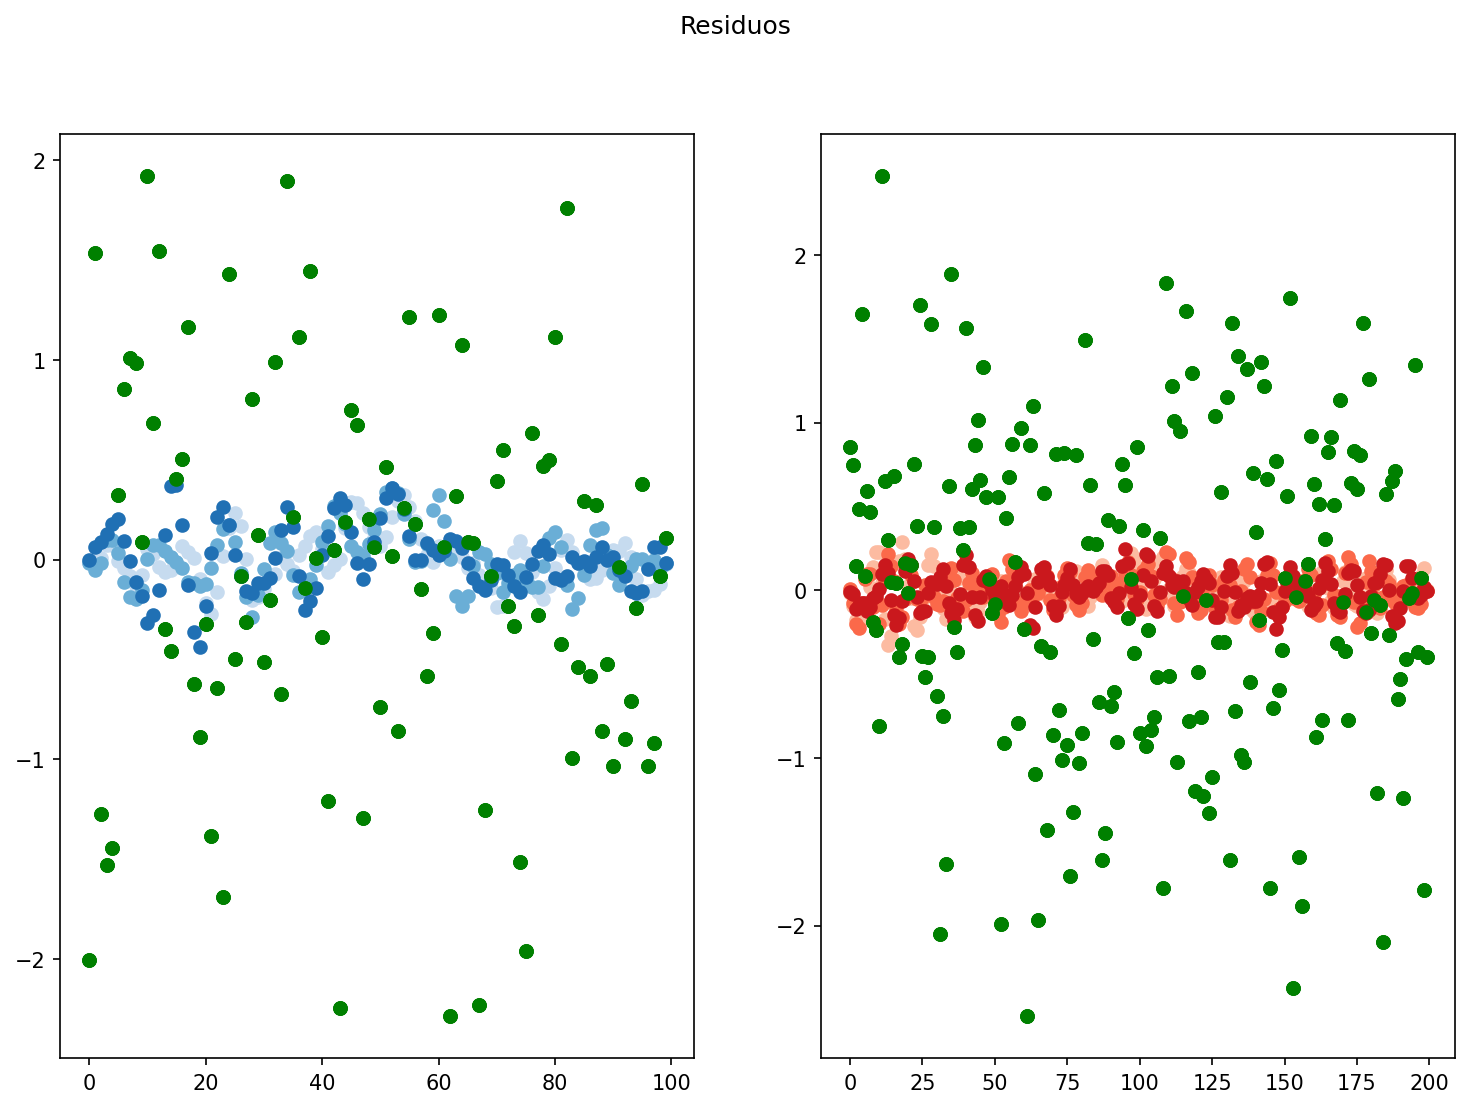

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

w = 0.10

resid_1hz = [_1hz_stresses[i] - butter_lowpass_filter(_1hz_stresses[i], w) for i in range(len(ids))]
resid_5hz = [_5hz_stresses[i] - butter_lowpass_filter(_5hz_stresses[i], w) for i in range(len(ids))]
control1 = np.random.normal(0,1,100)
control2 = np.random.normal(0,1,200)

for i in range(len(ids)):
    ax[0].scatter(np.arange(*resid_1hz[i].shape), resid_1hz[i], color=cmap1[i])
    ax[1].scatter(np.arange(*resid_5hz[i].shape), resid_5hz[i], color=cmap5[i])
    ax[0].scatter(np.arange(*control1.shape), control1, color='green')
    ax[1].scatter(np.arange(*control2.shape), control2,  color='green')

fig.suptitle("Residuos")
plt.show()

In [44]:
standardized_resid_1hz = []
standardized_resid_5hz = []

for i in range(len(ids)):
    standardized_resid_1hz.append(Standardize(resid_1hz[i]))
    standardized_resid_5hz.append(Standardize(resid_5hz[i]))

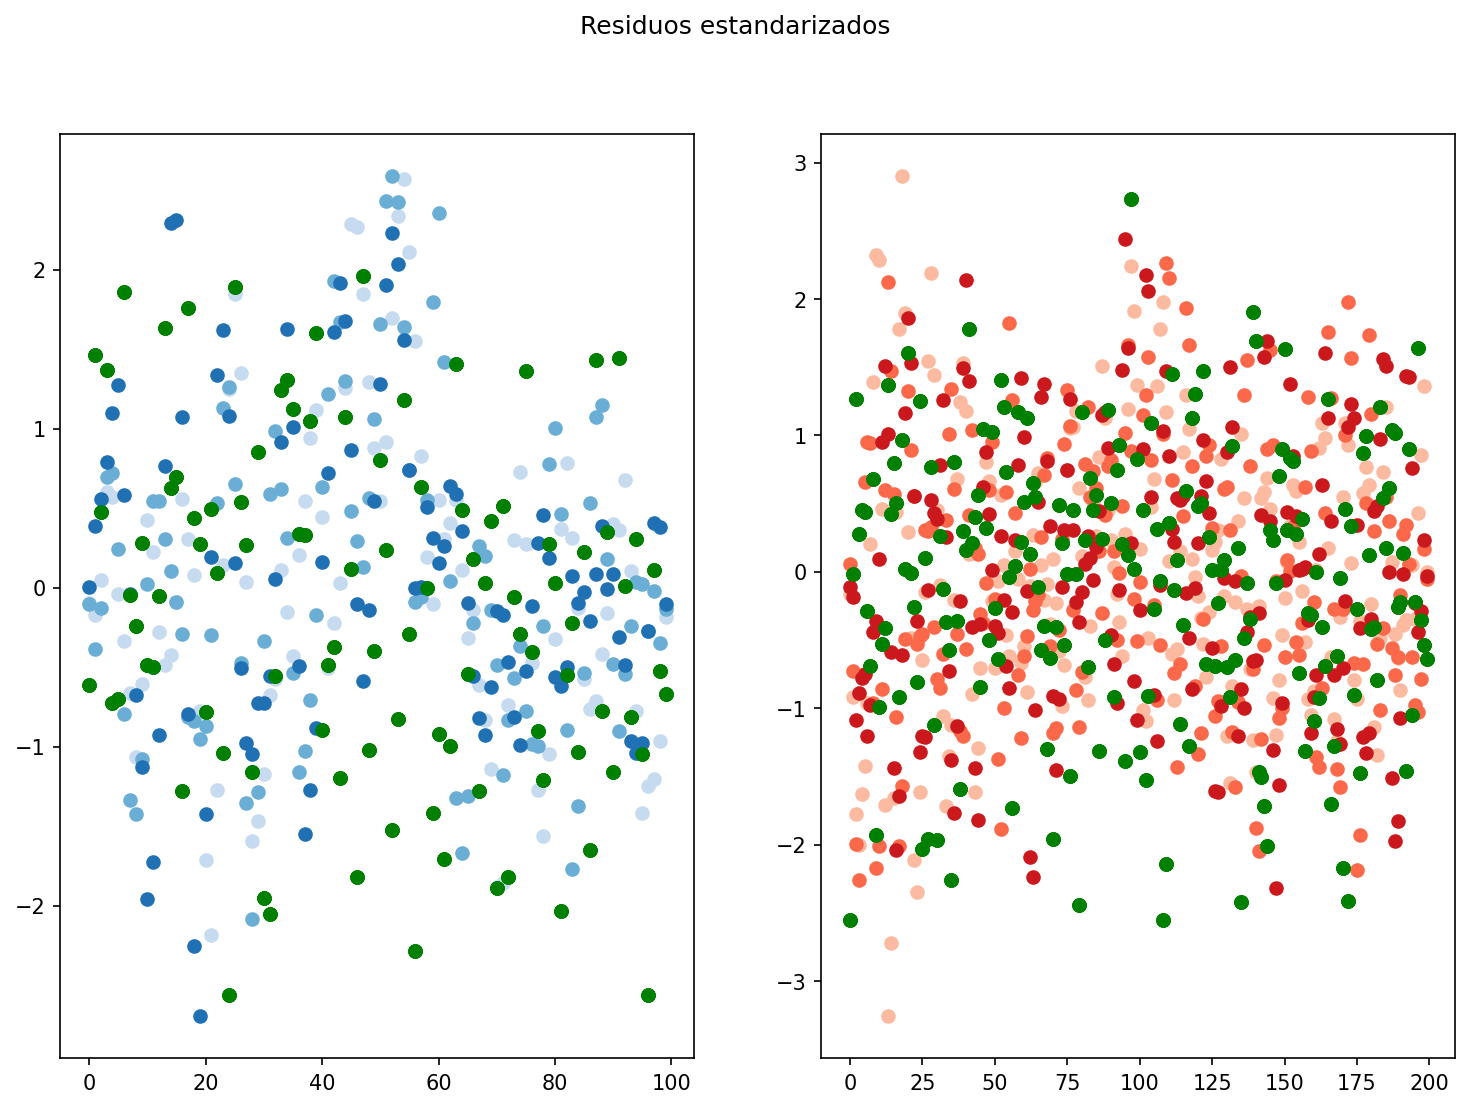

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

control1 = np.random.normal(0,1,100)
control2 = np.random.normal(0,1,200)


for i in range(len(ids)):
    ax[0].scatter(np.arange(*standardized_resid_1hz[i].shape), standardized_resid_1hz[i], color=cmap1[i])
    ax[1].scatter(np.arange(*standardized_resid_5hz[i].shape), standardized_resid_5hz[i], color=cmap5[i])
    ax[0].scatter(np.arange(*control1.shape), control1, color='green')
    ax[1].scatter(np.arange(*control2.shape), control2, color='green')

fig.suptitle("Residuos estandarizados")

plt.show()

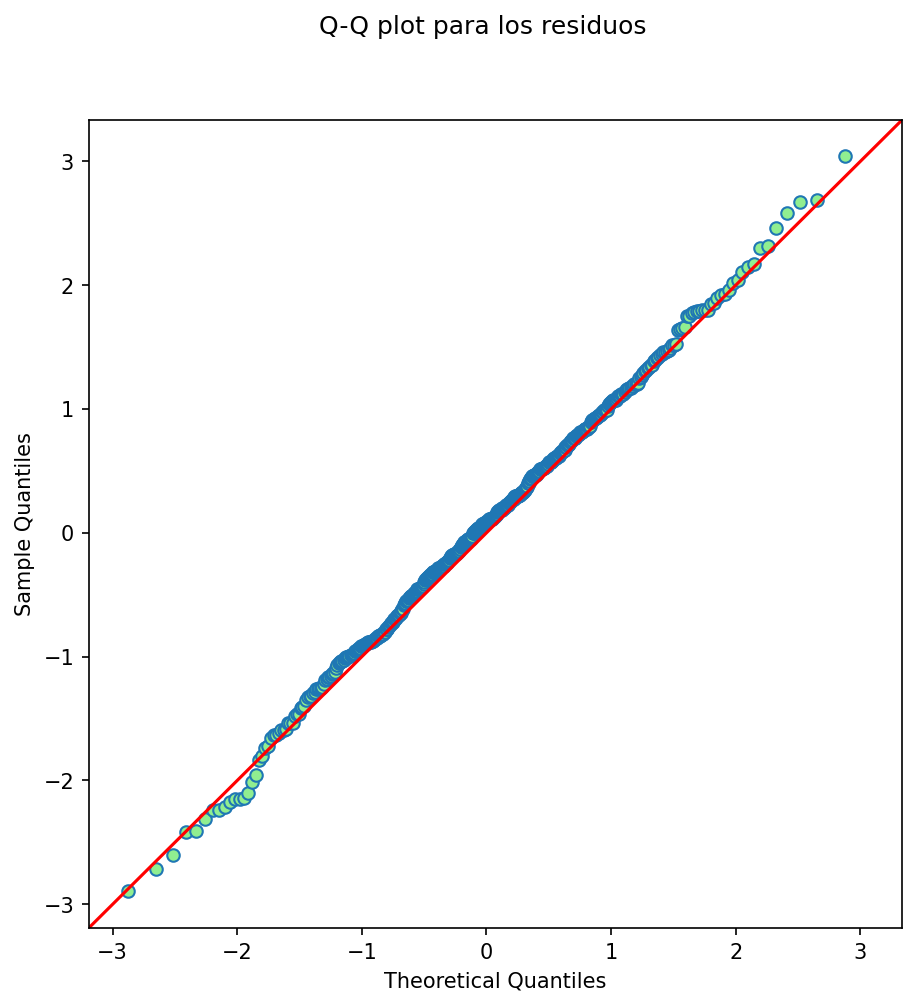

In [46]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150)

normals = np.random.normal(0,1,500)

sm.qqplot(normals, line="45", ax=ax, markerfacecolor= "lightgreen")

fig.suptitle("Q-Q plot para los residuos")

plt.show()

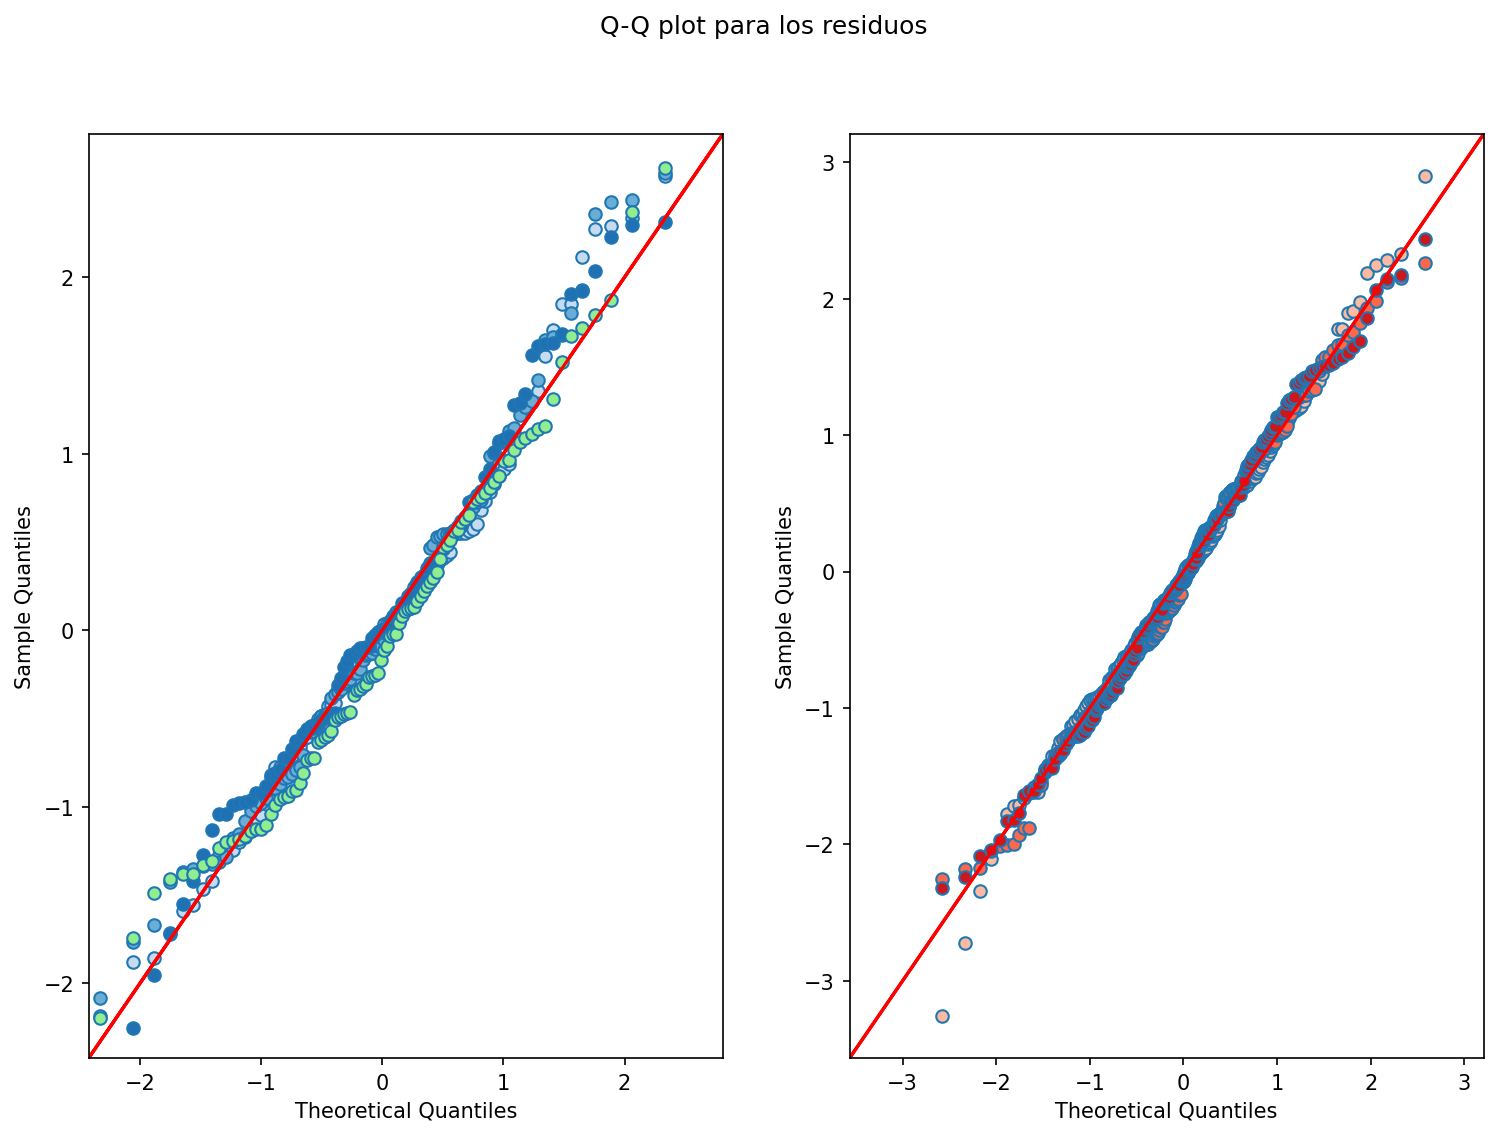

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

normals = np.random.normal(0,1,100)

for i in range(len(ids)):
    sm.qqplot(standardized_resid_1hz[i], line="45", ax=ax[0], markerfacecolor= cmap1[i])
    sm.qqplot(standardized_resid_5hz[i], line="45", ax=ax[1],markerfacecolor= cmap5[i])

sm.qqplot(normals, line="45", ax=ax[0], markerfacecolor= "lightgreen")

fig.suptitle("Q-Q plot para los residuos")

plt.show()

In [50]:
SW_control, SW_control_pvalue = stats.shapiro(normals)
print(f"Shapiro-Wilk p_value (control) = {SW_control}")

Shapiro-Wilk p_value (control) = 0.9823852777481079


In [49]:
for i in range(len(ids)):
    SW_1, SW_1_pvalue = stats.shapiro(resid_1hz[i])
    print(f"Shapiro-Wilk statistic (1hz residual {i}) = {SW_1}")
    SW_5, SW_5_pvalue = stats.shapiro(resid_5hz[i])
    print(f"Shapiro-Wilk statistic (5hz residual {i}) SW = {SW_5}")

Shapiro-Wilk statistic (1hz residual 0) = 0.9837214946746826
Shapiro-Wilk statistic (5hz residual 0) SW = 0.9971499443054199
Shapiro-Wilk statistic (1hz residual 1) = 0.9810778498649597
Shapiro-Wilk statistic (5hz residual 1) SW = 0.9886257648468018
Shapiro-Wilk statistic (1hz residual 2) = 0.9867236614227295
Shapiro-Wilk statistic (5hz residual 2) SW = 0.9909827709197998
